In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)



In [2]:
# Load the Ames Housing dataset
df_raw = pd.read_csv("AmesHousing.csv")

print("AMES HOUSING DATASET - INITIAL EXPLORATION")

print(f"Dataset shape: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns")
print(f"\nTarget variable: SalePrice")
print(f"Sale Price range: ${df_raw['SalePrice'].min():,.0f} - ${df_raw['SalePrice'].max():,.0f}")
print(f"Mean Sale Price: ${df_raw['SalePrice'].mean():,.0f}")
print(f"Median Sale Price: ${df_raw['SalePrice'].median():,.0f}")

# Check feature types
numeric_cols = df_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_raw.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature Composition:")
print(f"- Numeric features: {len(numeric_cols)}")
print(f"- Categorical features: {len(categorical_cols)}")



AMES HOUSING DATASET - INITIAL EXPLORATION
Dataset shape: 2930 rows × 82 columns

Target variable: SalePrice
Sale Price range: $12,789 - $755,000
Mean Sale Price: $180,796
Median Sale Price: $160,000

Feature Composition:
- Numeric features: 39
- Categorical features: 43


In [ ]:
# Visualize target variable distribution to detect imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Histogram
axes[0].hist(df_raw['SalePrice'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(df_raw['SalePrice'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df_raw["SalePrice"].mean():,.0f}')
axes[0].axvline(df_raw['SalePrice'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${df_raw["SalePrice"].median():,.0f}')
axes[0].set_xlabel('Sale Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Sale Prices (Original)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Binned distribution to show imbalance
bins = [0, 100000, 150000, 200000, 250000, 300000, 500000, 1000000]
bin_labels = ['<100K', '100-150K', '150-200K', '200-250K', '250-300K', '300-500K', '>500K']
df_raw['PriceBin'] = pd.cut(df_raw['SalePrice'], bins=bins, labels=bin_labels)
bin_counts = df_raw['PriceBin'].value_counts().sort_index()

axes[1].bar(range(len(bin_counts)), bin_counts.values, color='coral', edgecolor='black')
axes[1].set_xticks(range(len(bin_counts)))
axes[1].set_xticklabels(bin_counts.index, rotation=45, ha='right')
axes[1].set_xlabel('Price Range', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Imbalance: Rare vs Common Price Ranges', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Quantify imbalance

print("IMBALANCE ANALYSIS")
print("\nDistribution by Price Range:")
print(bin_counts)
print(f"\nImbalance Detected:")
print(f"- Expensive houses (>$300K): {bin_counts['>500K'] + bin_counts['300-500K']} samples ({((bin_counts['>500K'] + bin_counts['300-500K'])/len(df_raw)*100):.1f}%)")
print(f"- Cheap houses (<$100K): {bin_counts['<100K']} samples ({(bin_counts['<100K']/len(df_raw)*100):.1f}%)")
print(f"- Common range ($150-250K): {bin_counts['150-200K'] + bin_counts['200-250K']} samples ({((bin_counts['150-200K'] + bin_counts['200-250K'])/len(df_raw)*100):.1f}%)")

# Calculate skewness
skewness = df_raw['SalePrice'].skew()
print(f"\nSkewness: {skewness:.3f} (Right-skewed distribution)")
df_raw = df_raw.drop('PriceBin', axis=1)  # Remove temporary column


In [5]:
# Create a copy for processing
df = df_raw.copy()

print("DATA CLEANING")

# Drop rows with excessive missing values (>80% missing)
initial_rows = len(df)
df = df.dropna(thresh=len(df.columns)*0.8)
print(f"Rows removed (>80% missing): {initial_rows - len(df)}")

# Fill remaining missing values
missing_before = df.isnull().sum().sum()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])  # Most frequent for categorical
    else:
        df[col] = df[col].fillna(df[col].median())  # Median for numeric

missing_after = df.isnull().sum().sum()
print(f"Missing values handled: {missing_before} → {missing_after}")
print(f"Final dataset shape: {df.shape}")
print("\nData cleaning completed!")


DATA CLEANING
Rows removed (>80% missing): 1
Missing values handled: 15732 → 0
Final dataset shape: (2929, 82)

Data cleaning completed!


IMBALANCE MANAGEMENT

Log Transformation Applied
   Original skewness: 1.745
   After log transform: -0.013


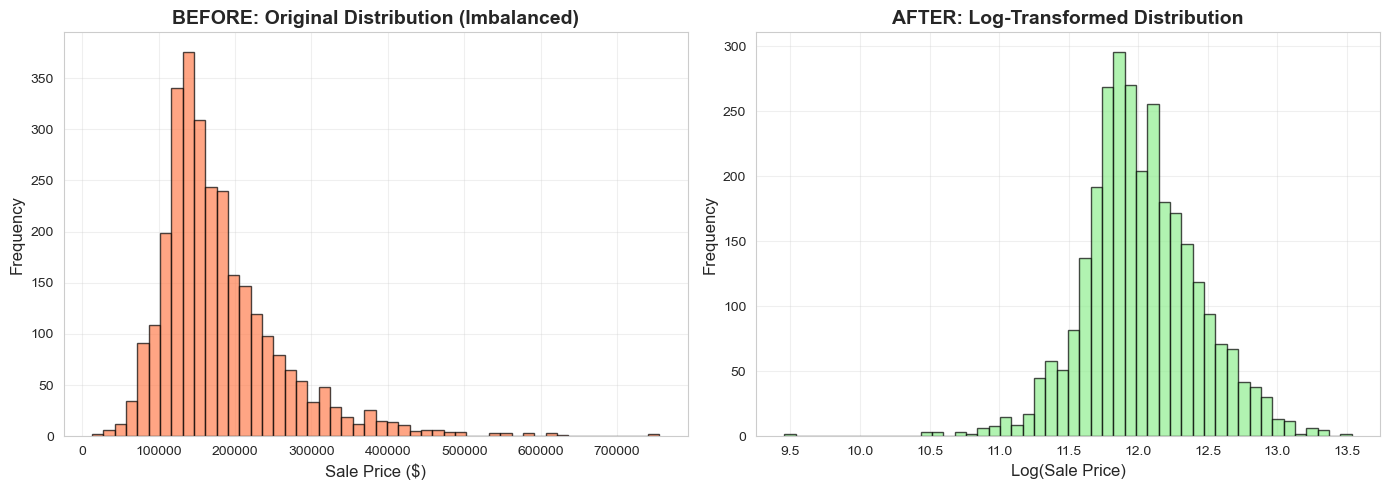

In [6]:
# IMBALANCE MANAGEMENT Log Transformation to reduce skewness

print("IMBALANCE MANAGEMENT")

# Store original for comparison
original_prices = df['SalePrice'].copy()

# Apply log transformation to reduce impact of extreme values
df['SalePrice'] = np.log1p(df['SalePrice'])

print("\nLog Transformation Applied")
print(f"   Original skewness: {original_prices.skew():.3f}")
print(f"   After log transform: {df['SalePrice'].skew():.3f}")


# Visualize for before/after transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(original_prices, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_xlabel('Sale Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('BEFORE: Original Distribution (Imbalanced)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(df['SalePrice'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Log(Sale Price)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('AFTER: Log-Transformed Distribution', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



Stratified Sampling
- Train set size: 2343 samples
- Test set size: 586 samples


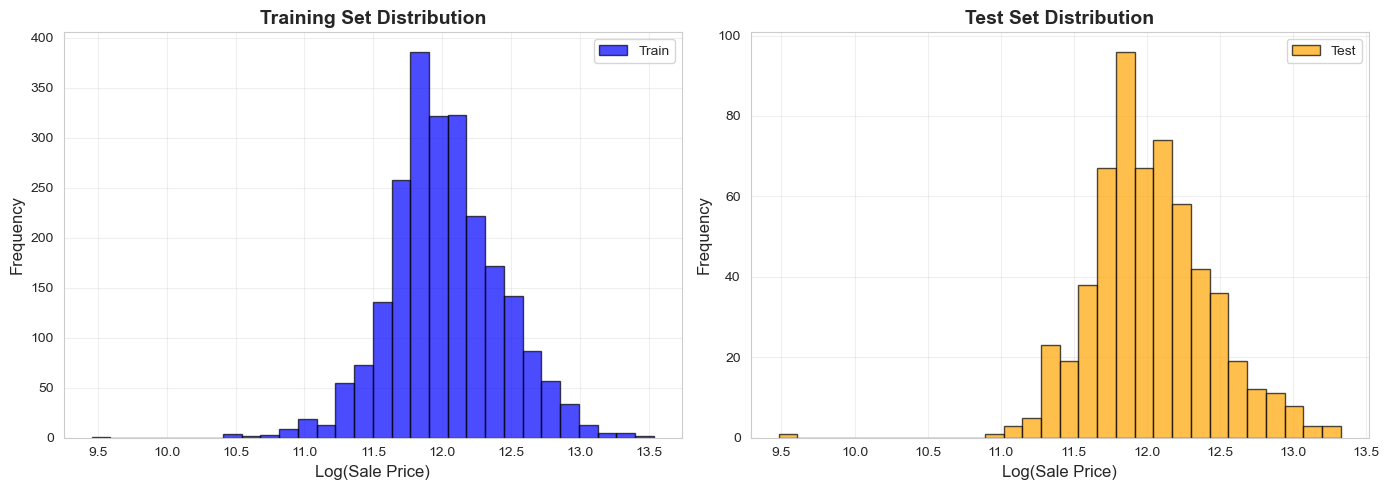

In [7]:
# IMBALANCE MANAGEMENT Stratified Train-Test Split
print("\nStratified Sampling")

# Create bins for stratification (ensuring rare values are represented)
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

# Create stratification bins based on quantiles (80/20)
n_bins = 5
stratify_bins = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

# Perform stratified split
X_train, X_test, y_train, y_test, bins_train, bins_test = train_test_split(
    X, y, stratify_bins, test_size=0.2, random_state=42, stratify=stratify_bins
)
#Stratified split ensures rare values in BOTH sets
print(f"- Train set size: {len(X_train)} samples")
print(f"- Test set size: {len(X_test)} samples")


# Verify distribution is maintained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=30, alpha=0.7, color='blue', label='Train', edgecolor='black')
axes[0].set_xlabel('Log(Sale Price)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(y_test, bins=30, alpha=0.7, color='orange', label='Test', edgecolor='black')
axes[1].set_xlabel('Log(Sale Price)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [8]:
# Identify feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


print("FEATURE PREPROCESSING PIPELINE")
print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Create preprocessing pipelines
numeric_transformer = StandardScaler()  # Normalize numeric features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # Encode categorical features

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\nPreprocessing pipeline created:")
print("- Numeric: StandardScaler (normalization)")
print("- Categorical: OneHotEncoder (handles non-numeric features)")


FEATURE PREPROCESSING PIPELINE

Numeric features: 38
Categorical features: 43

Preprocessing pipeline created:
- Numeric: StandardScaler (normalization)
- Categorical: OneHotEncoder (handles non-numeric features)


In [9]:
print("MODEL 1: XGBoost - HYPERPARAMETER TUNING")

# Create pipeline: preprocessing + model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Define hyperparameter search space
param_grid_xgb = {
    'model__n_estimators': [200, 300, 400],      # Number of trees
    'model__max_depth': [3, 5, 7],               # Tree depth (controls complexity)
    'model__learning_rate': [0.01, 0.05, 0.1],   # Step size shrinkage
    'model__subsample': [0.6, 0.8, 1.0],         # Sample fraction per tree
    'model__colsample_bytree': [0.6, 0.8, 1.0]   # Feature fraction per tree
}

print("\nHyperparameter Search Space:")
for param, values in param_grid_xgb.items():
    print(f"   {param}: {values}")

# Calculate total combinations
total_combinations = 1
for values in param_grid_xgb.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to test: {total_combinations}")

# Grid search with cross-validation
grid_search_xgb = GridSearchCV(
    xgb_pipeline, 
    param_grid=param_grid_xgb,
    scoring='r2',  # Optimization metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

print("\nTraining XGBoost with GridSearchCV")
grid_search_xgb.fit(X_train, y_train)

# Get best model
best_xgb = grid_search_xgb.best_estimator_
print("\nTraining complete!")
print(f"\nBest Hyperparameters:")
for param, value in grid_search_xgb.best_params_.items():
    print(f"   {param}: {value}")
print(f"\nBest CV Score (R²): {grid_search_xgb.best_score_:.4f}")


MODEL 1: XGBoost - HYPERPARAMETER TUNING

Hyperparameter Search Space:
   model__n_estimators: [200, 300, 400]
   model__max_depth: [3, 5, 7]
   model__learning_rate: [0.01, 0.05, 0.1]
   model__subsample: [0.6, 0.8, 1.0]
   model__colsample_bytree: [0.6, 0.8, 1.0]

Total combinations to test: 243

Training XGBoost with GridSearchCV
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Training complete!

Best Hyperparameters:
   model__colsample_bytree: 1.0
   model__learning_rate: 0.1
   model__max_depth: 3
   model__n_estimators: 400
   model__subsample: 0.6

Best CV Score (R²): 0.9171


EVALUATING XGBOOST MODEL
XGBoost (Optimized) - PERFORMANCE METRICS
RMSE (Root Mean Squared Error): 0.1266
MAE  (Mean Absolute Error):     0.0751
R²   (Coefficient of Determination): 0.9054

Interpretation:
   - R² = 0.9054 - Model explains 90.54% of variance
   - Average prediction error: 0.0751 log-units (approx $0 in original scale)


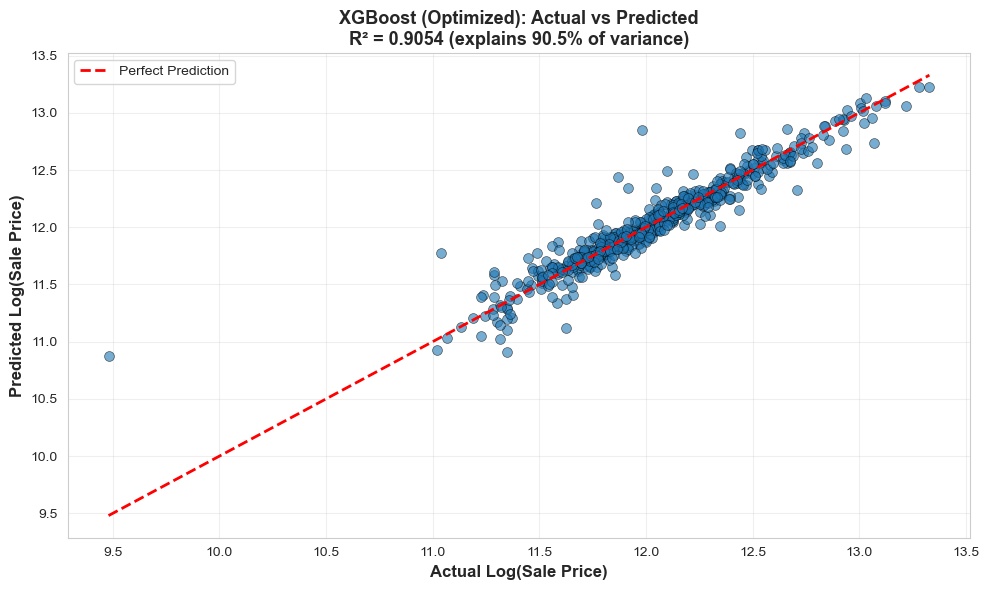

In [10]:
# Define evaluation function with visualization
def evaluate_model(y_true, y_pred, model_name):
 
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Print metrics
  
    print(f"{model_name} - PERFORMANCE METRICS")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAE  (Mean Absolute Error):     {mae:.4f}")
    print(f"R²   (Coefficient of Determination): {r2:.4f}")
    print(f"\nInterpretation:")
    print(f"   - R² = {r2:.4f} - Model explains {r2*100:.2f}% of variance")
    print(f"   - Average prediction error: {mae:.4f} log-units (approx ${np.expm1(mae):,.0f} in original scale)")

    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5, s=50)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual Log(Sale Price)', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted Log(Sale Price)', fontsize=12, fontweight='bold')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2:.4f} (explains {r2*100:.1f}% of variance)', 
              fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return rmse, mae, r2


print("EVALUATING XGBOOST MODEL")


# Make predictions (using test dataset)
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate
metrics_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost (Optimized)")



In [11]:
print("MODEL 2: Multi-Layer Perceptron - HYPERPARAMETER TUNING")

# Create MLP pipeline
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(max_iter=5000, random_state=42, early_stopping=True, validation_fraction=0.15))
])

# Define hyperparameter search space for MLP
param_grid_mlp = {
    'model__hidden_layer_sizes': [(128,), (256,), (512,), (128, 64), (256, 128), (512, 256)],  # Network architecture
    'model__learning_rate_init': [0.001, 0.005, 0.01],  # Initial learning rate
    'model__activation': ['relu', 'tanh'],  # Activation function
    'model__alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'model__solver': ['adam']  # Optimizer
}

print("\nHyperparameter Search Space:")
print(f"hidden_layer_sizes: {param_grid_mlp['model__hidden_layer_sizes']}")
print(f"learning_rate_init: {param_grid_mlp['model__learning_rate_init']}")
print(f"activation: {param_grid_mlp['model__activation']}")
print(f"alpha (regularization): {param_grid_mlp['model__alpha']}")


# Grid search with cross-validation
grid_search_mlp = GridSearchCV(
    mlp_pipeline,
    param_grid=param_grid_mlp,
    cv=3,  # 3-fold cross-validation
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

print("\nTraining MLP with GridSearchCV")
grid_search_mlp.fit(X_train, y_train)

# Get best model
best_mlp = grid_search_mlp.best_estimator_
print("\nTraining complete!")
print(f"\nBest Hyperparameters:")
for param, value in grid_search_mlp.best_params_.items():
    print(f"   {param}: {value}")
print(f"\nBest CV Score (R²): {grid_search_mlp.best_score_:.4f}")


MODEL 2: Multi-Layer Perceptron - HYPERPARAMETER TUNING

Hyperparameter Search Space:
hidden_layer_sizes: [(128,), (256,), (512,), (128, 64), (256, 128), (512, 256)]
learning_rate_init: [0.001, 0.005, 0.01]
activation: ['relu', 'tanh']
alpha (regularization): [0.0001, 0.001, 0.01]

Training MLP with GridSearchCV
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Training complete!

Best Hyperparameters:
   model__activation: tanh
   model__alpha: 0.01
   model__hidden_layer_sizes: (512, 256)
   model__learning_rate_init: 0.005
   model__solver: adam

Best CV Score (R²): 0.9129


EVALUATING MLP MODEL
MLP (Optimized) - PERFORMANCE METRICS
RMSE (Root Mean Squared Error): 0.1351
MAE  (Mean Absolute Error):     0.0801
R²   (Coefficient of Determination): 0.8923

Interpretation:
   - R² = 0.8923 - Model explains 89.23% of variance
   - Average prediction error: 0.0801 log-units (approx $0 in original scale)


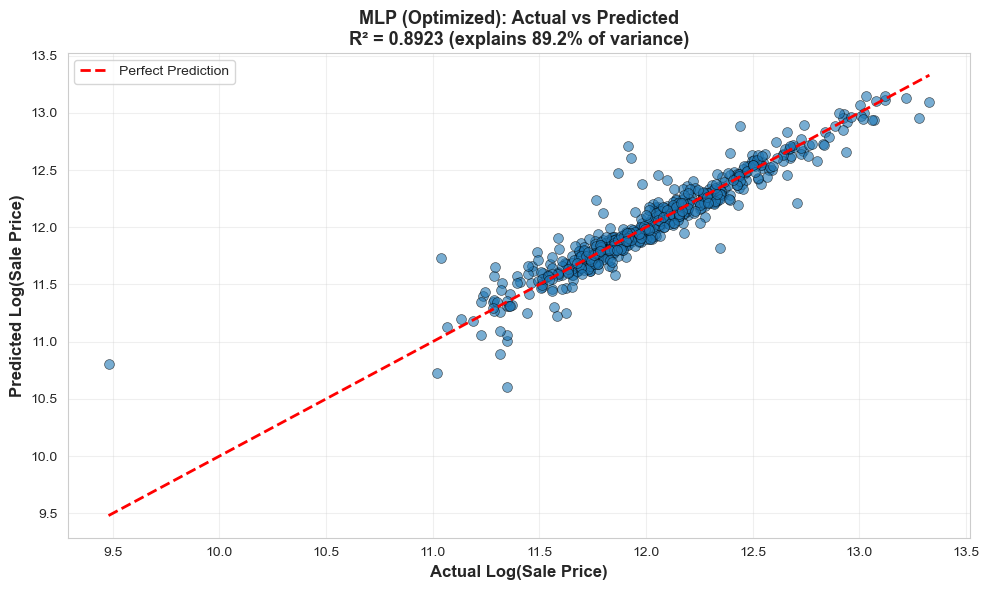

In [12]:
print("EVALUATING MLP MODEL")

# Make predictions
y_pred_mlp = best_mlp.predict(X_test)

# Evaluate
metrics_mlp = evaluate_model(y_test, y_pred_mlp, "MLP (Optimized)")




MODEL COMPARISON

                   Model     RMSE      MAE       R²
XGBoost (Traditional ML) 0.126638 0.075087 0.905355
     MLP (Deep Learning) 0.135076 0.080124 0.892322

Best Individual Model: XGBoost

Analysis:
   - XGBoost R²: 0.9054
   - MLP R²: 0.8923
   - Performance difference: 0.0130


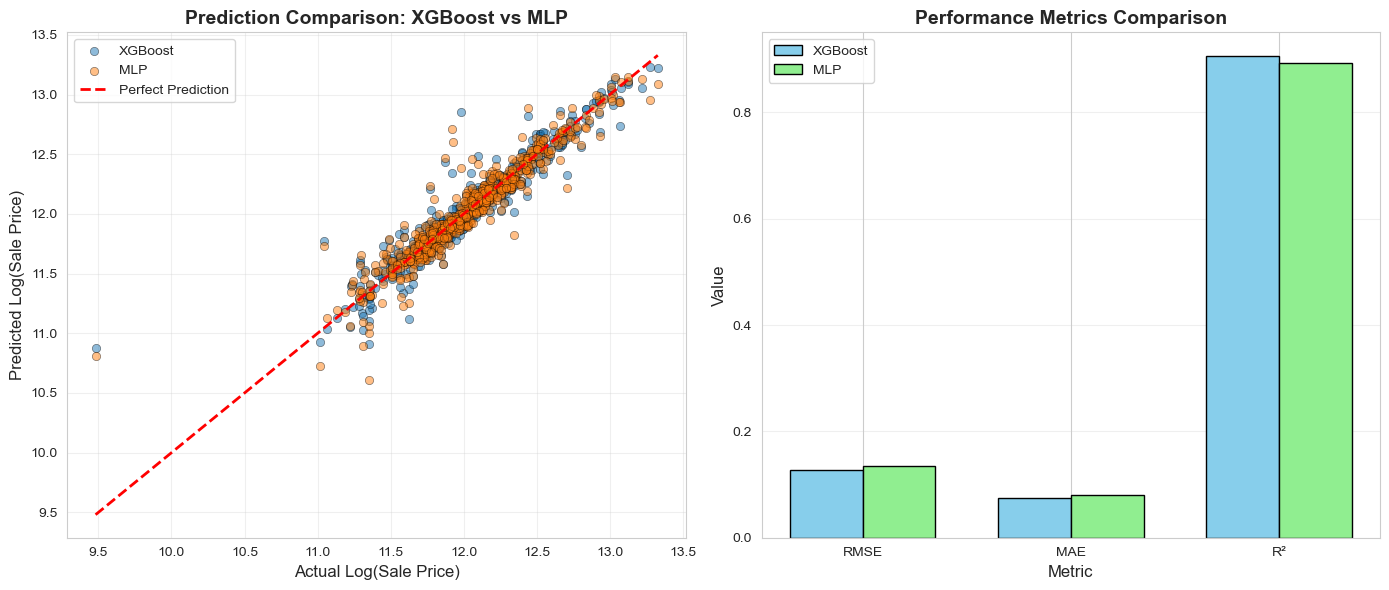

In [13]:
print("MODEL COMPARISON")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['XGBoost (Traditional ML)', 'MLP (Deep Learning)'],
    'RMSE': [metrics_xgb[0], metrics_mlp[0]],
    'MAE': [metrics_xgb[1], metrics_mlp[1]],
    'R²': [metrics_xgb[2], metrics_mlp[2]]
})

print("\n" + comparison_df.to_string(index=False))

# Determine best model
best_individual = 'XGBoost' if metrics_xgb[2] > metrics_mlp[2] else 'MLP'
print(f"\nBest Individual Model: {best_individual}")
print(f"\nAnalysis:")
print(f"   - XGBoost R²: {metrics_xgb[2]:.4f}")
print(f"   - MLP R²: {metrics_mlp[2]:.4f}")
print(f"   - Performance difference: {abs(metrics_xgb[2] - metrics_mlp[2]):.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Compare predictions
axes[0].scatter(y_test, y_pred_xgb, alpha=0.5, label='XGBoost', edgecolors='k', linewidth=0.5)
axes[0].scatter(y_test, y_pred_mlp, alpha=0.5, label='MLP', edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Log(Sale Price)', fontsize=12)
axes[0].set_ylabel('Predicted Log(Sale Price)', fontsize=12)
axes[0].set_title('Prediction Comparison: XGBoost vs MLP', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Metric comparison bar chart
metrics_names = ['RMSE', 'MAE', 'R²']
x_pos = np.arange(len(metrics_names))
xgb_metrics = [metrics_xgb[0], metrics_xgb[1], metrics_xgb[2]]
mlp_metrics = [metrics_mlp[0], metrics_mlp[1], metrics_mlp[2]]

width = 0.35
axes[1].bar(x_pos - width/2, xgb_metrics, width, label='XGBoost', color='skyblue', edgecolor='black')
axes[1].bar(x_pos + width/2, mlp_metrics, width, label='MLP', color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Metric', fontsize=12)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(metrics_names)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


ENSEMBLE METHOD - INITIAL
Initial Ensemble (50-50) - PERFORMANCE METRICS
RMSE (Root Mean Squared Error): 0.1249
MAE  (Mean Absolute Error):     0.0735
R²   (Coefficient of Determination): 0.9080

Interpretation:
   - R² = 0.9080 - Model explains 90.80% of variance
   - Average prediction error: 0.0735 log-units (approx $0 in original scale)


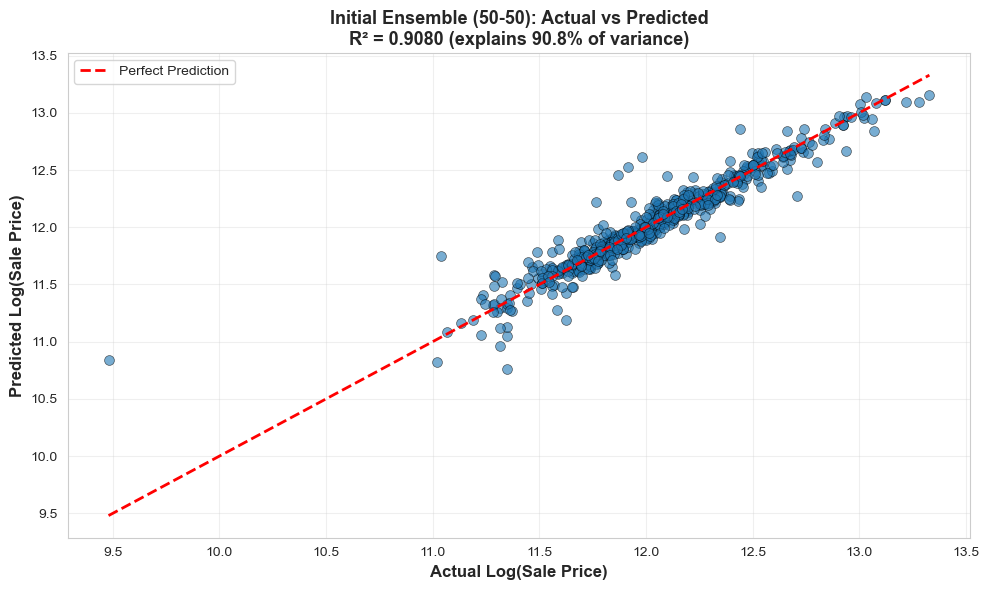


Improvement over individual models:
   vs XGBoost: 0.26% improvement
   vs MLP: 1.56% improvement


In [14]:
print("ENSEMBLE METHOD - INITIAL")


# Initial ensemble: equal weights (50-50)
y_pred_ensemble_init = 0.5 * y_pred_xgb + 0.5 * y_pred_mlp

# Evaluate initial ensemble
metrics_ensemble_init = evaluate_model(y_test, y_pred_ensemble_init, "Initial Ensemble (50-50)")

print(f"\nImprovement over individual models:")
print(f"   vs XGBoost: {(metrics_ensemble_init[2] - metrics_xgb[2])*100:.2f}% {'improvement' if metrics_ensemble_init[2] > metrics_xgb[2] else 'decline'}")
print(f"   vs MLP: {(metrics_ensemble_init[2] - metrics_mlp[2])*100:.2f}% improvement")


ENSEMBLE OPTIMIZATION

Tested 51 weight combinations

OPTIMAL ENSEMBLE WEIGHTS:
   XGBoost: 0.68 (68.0%)
   MLP:     0.32 (32.0%)
   Best R²: 0.9091


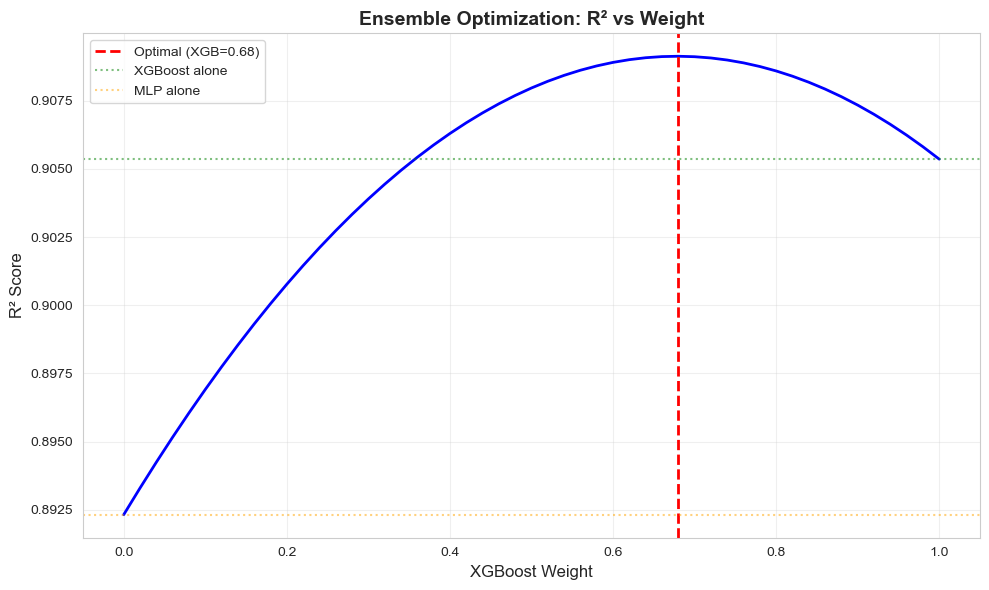

In [15]:
print("ENSEMBLE OPTIMIZATION")


# Search for optimal weights
weight_range = np.linspace(0, 1, 51)  # Test 51 different weight combinations
results = []

for w_xgb in weight_range:
    w_mlp = 1 - w_xgb
    y_pred_temp = w_xgb * y_pred_xgb + w_mlp * y_pred_mlp
    r2_temp = r2_score(y_test, y_pred_temp)
    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    results.append({
        'XGBoost_Weight': w_xgb,
        'MLP_Weight': w_mlp,
        'R2': r2_temp,
        'RMSE': rmse_temp
    })

results_df = pd.DataFrame(results)

# Find optimal weights
best_idx = results_df['R2'].idxmax()
best_weight_xgb = results_df.loc[best_idx, 'XGBoost_Weight']
best_weight_mlp = results_df.loc[best_idx, 'MLP_Weight']
best_r2 = results_df.loc[best_idx, 'R2']

print(f"\nTested {len(weight_range)} weight combinations")
print(f"\nOPTIMAL ENSEMBLE WEIGHTS:")
print(f"   XGBoost: {best_weight_xgb:.2f} ({best_weight_xgb*100:.1f}%)")
print(f"   MLP:     {best_weight_mlp:.2f} ({best_weight_mlp*100:.1f}%)")
print(f"   Best R²: {best_r2:.4f}")

# Visualize optimization process
plt.figure(figsize=(10, 6))

plt.plot(results_df['XGBoost_Weight'], results_df['R2'], linewidth=2, color='blue')
plt.axvline(best_weight_xgb, color='red', linestyle='--', linewidth=2, 
            label=f'Optimal (XGB={best_weight_xgb:.2f})')
plt.axhline(metrics_xgb[2], color='green', linestyle=':', alpha=0.5, label='XGBoost alone')
plt.axhline(metrics_mlp[2], color='orange', linestyle=':', alpha=0.5, label='MLP alone')
plt.xlabel('XGBoost Weight', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Ensemble Optimization: R² vs Weight', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Optimized Ensemble - PERFORMANCE METRICS
RMSE (Root Mean Squared Error): 0.1241
MAE  (Mean Absolute Error):     0.0730
R²   (Coefficient of Determination): 0.9091

Interpretation:
   - R² = 0.9091 - Model explains 90.91% of variance
   - Average prediction error: 0.0730 log-units (approx $0 in original scale)


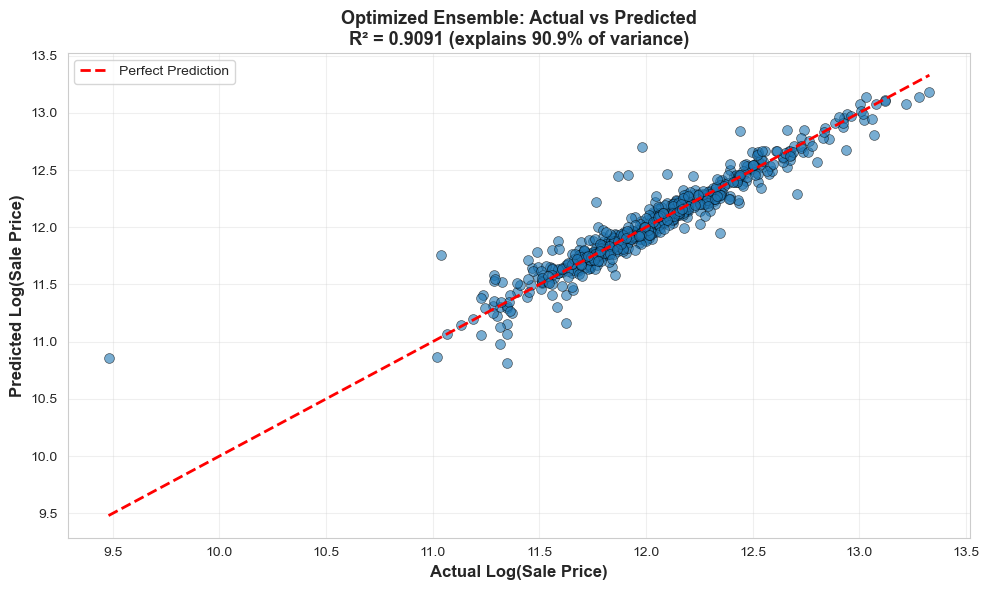

In [16]:
# Create optimized ensemble predictions
y_pred_ensemble_opt = best_weight_xgb * y_pred_xgb + best_weight_mlp * y_pred_mlp

# Evaluate optimized ensemble
metrics_ensemble_opt = evaluate_model(y_test, y_pred_ensemble_opt, "Optimized Ensemble")




In [17]:
print("FINAL RESULTS - ALL MODELS")


# Create table comparison
final_comparison = pd.DataFrame({
    'Model': [
        'XGBoost (Optimized)', 
        'MLP (Optimized)', 
        'Ensemble (Initial 50-50)', 
        'Ensemble (Optimized)'
    ],
    'RMSE': [
        metrics_xgb[0], 
        metrics_mlp[0], 
        metrics_ensemble_init[0], 
        metrics_ensemble_opt[0]
    ],
    'MAE': [
        metrics_xgb[1], 
        metrics_mlp[1], 
        metrics_ensemble_init[1], 
        metrics_ensemble_opt[1]
    ],
    'R²': [
        metrics_xgb[2], 
        metrics_mlp[2], 
        metrics_ensemble_init[2], 
        metrics_ensemble_opt[2]
    ]
})

print("\n")
print(final_comparison.to_string(index=False))

# SHow best model
best_model_idx = final_comparison['R²'].idxmax()
best_model_name = final_comparison.loc[best_model_idx, 'Model']
best_model_r2 = final_comparison.loc[best_model_idx, 'R²']

print(f"\n")
print(f"BEST MODEL: {best_model_name}")
print(f"- R² Score: {best_model_r2:.4f}")
print(f"- RMSE: {final_comparison.loc[best_model_idx, 'RMSE']:.4f}")
print(f"- MAE: {final_comparison.loc[best_model_idx, 'MAE']:.4f}")


# Calculate the improvements
improvement_over_xgb = ((metrics_ensemble_opt[2] - metrics_xgb[2]) / metrics_xgb[2]) * 100
improvement_over_mlp = ((metrics_ensemble_opt[2] - metrics_mlp[2]) / metrics_mlp[2]) * 100

print(f"\nEnsemble Optimization Impact:")
print(f"- Improvement over XGBoost: {improvement_over_xgb:+.2f}%")
print(f"- Improvement over MLP: {improvement_over_mlp:+.2f}%")
print(f"- Improvement from weight optimization: {((metrics_ensemble_opt[2] - metrics_ensemble_init[2]) / metrics_ensemble_init[2]) * 100:+.2f}%")


FINAL RESULTS - ALL MODELS


                   Model     RMSE      MAE       R²
     XGBoost (Optimized) 0.126638 0.075087 0.905355
         MLP (Optimized) 0.135076 0.080124 0.892322
Ensemble (Initial 50-50) 0.124882 0.073524 0.907963
    Ensemble (Optimized) 0.124090 0.073025 0.909126


BEST MODEL: Ensemble (Optimized)
- R² Score: 0.9091
- RMSE: 0.1241
- MAE: 0.0730

Ensemble Optimization Impact:
- Improvement over XGBoost: +0.42%
- Improvement over MLP: +1.88%
- Improvement from weight optimization: +0.13%


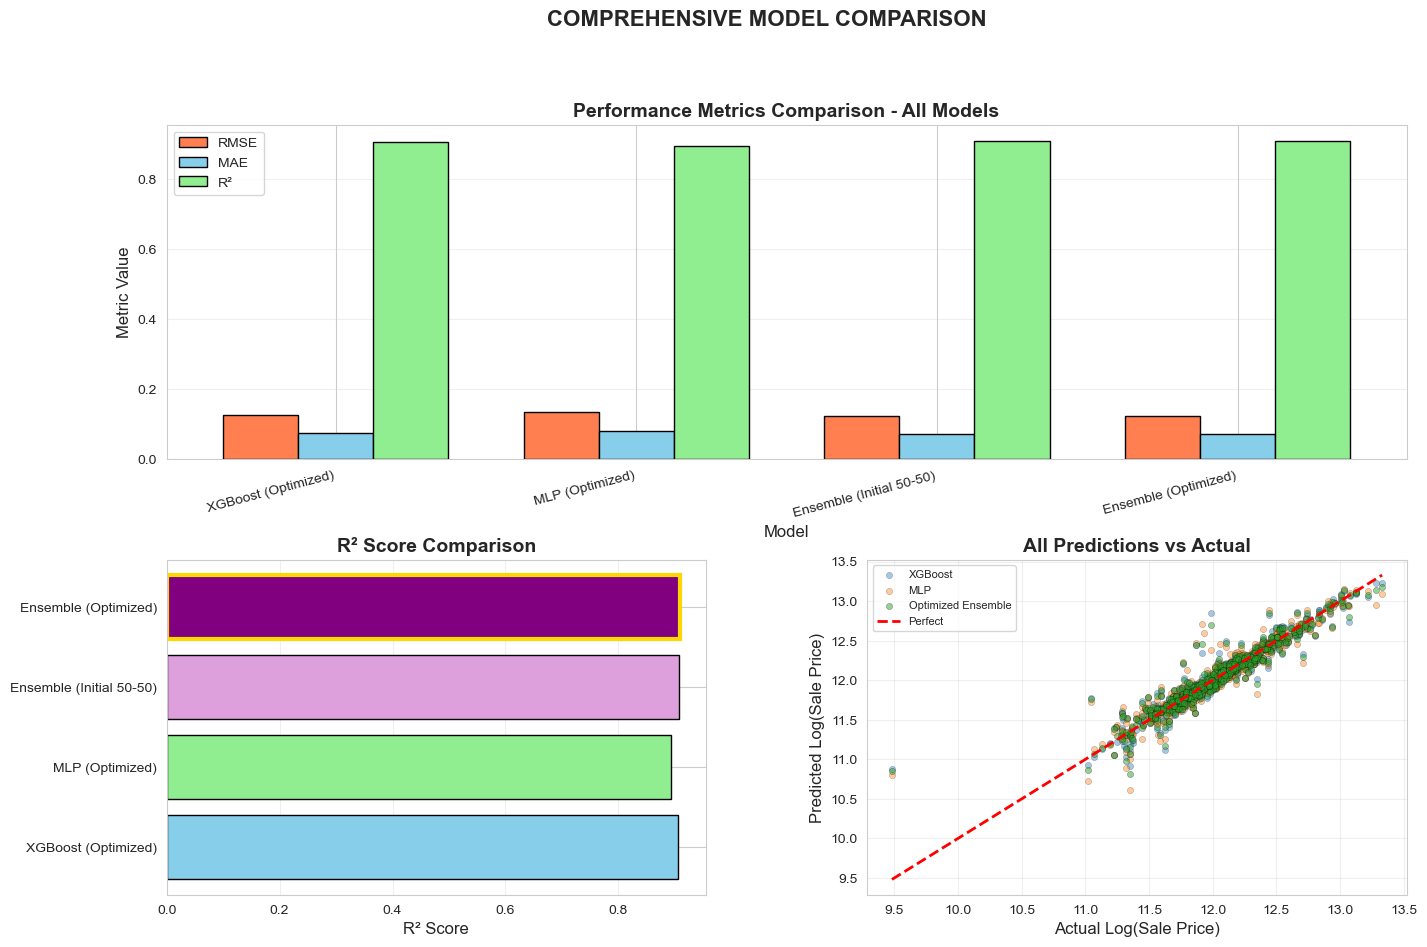

In [18]:
# Visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Bar chart comparison
ax1 = fig.add_subplot(gs[0, :])
x_pos = np.arange(len(final_comparison))
width = 0.25

ax1.bar(x_pos - width, final_comparison['RMSE'], width, label='RMSE', color='coral', edgecolor='black')
ax1.bar(x_pos, final_comparison['MAE'], width, label='MAE', color='skyblue', edgecolor='black')
ax1.bar(x_pos + width, final_comparison['R²'], width, label='R²', color='lightgreen', edgecolor='black')

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Metric Value', fontsize=12)
ax1.set_title('Performance Metrics Comparison - All Models', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(final_comparison['Model'], rotation=15, ha='right')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# 2. R² comparison
ax2 = fig.add_subplot(gs[1, 0])
colors = ['skyblue', 'lightgreen', 'plum', 'purple']
bars = ax2.barh(final_comparison['Model'], final_comparison['R²'], color=colors, edgecolor='black')
ax2.set_xlabel('R² Score', fontsize=12)
ax2.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# Highlight the best
best_idx = final_comparison['R²'].idxmax()
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

# 3. Prediction comparison scatter plot
ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(y_test, y_pred_xgb, alpha=0.4, s=20, label='XGBoost', edgecolors='k', linewidth=0.3)
ax3.scatter(y_test, y_pred_mlp, alpha=0.4, s=20, label='MLP', edgecolors='k', linewidth=0.3)
ax3.scatter(y_test, y_pred_ensemble_opt, alpha=0.5, s=20, label='Optimized Ensemble', 
            edgecolors='k', linewidth=0.3)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect')
ax3.set_xlabel('Actual Log(Sale Price)', fontsize=12)
ax3.set_ylabel('Predicted Log(Sale Price)', fontsize=12)
ax3.set_title('All Predictions vs Actual', fontsize=14, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)

plt.suptitle('COMPREHENSIVE MODEL COMPARISON', fontsize=16, fontweight='bold', y=0.995)
plt.show()
